In [1]:
# # adjsut the basic logging lovel of notebook
# import logging
# logging.basicConfig(level=logging.WARNING)

import os
import yaml
import numpy as np
import pandas as pd
import scipy as scp
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
# import seaborn as sns
from matplotlib.lines import Line2D
from palettable.colorbrewer import qualitative

from auditory_cortex.analyses import Correlations
from auditory_cortex import results_dir, aux_dir, saved_corr_dir, cache_dir
from auditory_cortex.utils import CorrelationUtils
from auditory_cortex.plotters.correlation_plotter import RegPlotter

from pycolormap_2d import ColorMap2DBremm, ColorMap2DZiegler
%matplotlib inline

#### combining results across layers...

In [12]:
num_layers = {
	'wav2letter_modified': 14,
	'deepspeech2': 7,
	'speech2text': 14,
	'whisper_tiny': 6,
	'whisper_base': 8,
	'wav2vec2': 21,
	'w2v2_audioset': 21,
	'w2v2_generic': 21,
}


def display_sessions_done(model_name, identifier, verbose=False, num_sessions=41):
	"""Display the number of sessions done for all bin widths
	"""
	if verbose:
		print(f"For '{model_name}', '{identifier}'")
	corr_obj = Correlations(model_name+'_'+identifier)
	bin_widths = np.sort(corr_obj.data['bin_width'].unique())
	return_list = []
	for bin_width in bin_widths:
		data = corr_obj.get_selected_data(bin_width=bin_width)
		if verbose:
			print(f"For bin_width: {bin_width:03} ms, sessions done: {len(data['session'].unique())}")
		if len(data['session'].unique()) != num_sessions:
			return_list.append(model_name+'_'+identifier+f'{bin_width}')
		else:
			return_list.append(None)
	return return_list

def check_saved_results(identifier, model_names=None, verbose=False, num_sessions=41):

	models_not_done = []
	if model_names is None:
		model_names = num_layers.keys()
	for model_name in model_names:
		not_done = display_sessions_done(
			model_name, identifier, verbose=verbose, num_sessions=num_sessions)
		models_not_done.extend(not_done)
		for i in range(1, num_layers[model_name]):
			not_done = display_sessions_done(
				model_name, identifier+f'_l{i}', verbose=verbose, num_sessions=num_sessions)
			models_not_done.extend(not_done)

	# remove None entries..
	while None in models_not_done:
		models_not_done.remove(None)
	
	if len(models_not_done) ==0:
		print(f"All models done..for {identifier}")
	else:
		print(f"Models with incomplete resutls:")
		for iden in models_not_done:
			print(iden)
	

def combine_results_for_all_models(identifier, model_names=None):
	"""Combines results for the list of models provided"""
	normalizer_filename = 'modified_bins_normalizer.csv'
	if model_names is None:
		model_names = num_layers.keys()
	for model_name in model_names:
		ids = [identifier] + [f'{identifier}_l{i}' for i in range(1, num_layers[model_name])]
		Correlations.combine_and_ready(
			model_name,
			ids, 0, normalizer_filename=normalizer_filename
			)
		


In [13]:
model_names = [
	# 'wav2vec2',
	# 'speech2text'
    # 'whisper_tiny',
	'whisper_base',
]
identifier = 'mVocs_trf_lags300'
check_saved_results(identifier, model_names=model_names, verbose=True, num_sessions=39)

For 'whisper_base', 'mVocs_trf_lags300'
Using default normalizer file...
For bin_width: 50.0 ms, sessions done: 16
For 'whisper_base', 'mVocs_trf_lags300_l1'
Using default normalizer file...
For bin_width: 50.0 ms, sessions done: 16
For 'whisper_base', 'mVocs_trf_lags300_l2'
Using default normalizer file...
For bin_width: 50.0 ms, sessions done: 10
For 'whisper_base', 'mVocs_trf_lags300_l3'
Using default normalizer file...
For bin_width: 50.0 ms, sessions done: 8
For 'whisper_base', 'mVocs_trf_lags300_l4'
Using default normalizer file...
For bin_width: 50.0 ms, sessions done: 12
For 'whisper_base', 'mVocs_trf_lags300_l5'
Using default normalizer file...
For bin_width: 50.0 ms, sessions done: 10
For 'whisper_base', 'mVocs_trf_lags300_l6'
Using default normalizer file...
For bin_width: 50.0 ms, sessions done: 11
For 'whisper_base', 'mVocs_trf_lags300_l7'
Using default normalizer file...
For bin_width: 50.0 ms, sessions done: 9
Models with incomplete resutls:
whisper_base_mVocs_trf_lags30

#### combining results across sessions...

In [31]:
def display_sessions_done(model_name, identifier, verbose=False):
	"""Display the number of sessions done for all bin widths
	"""
	if verbose:
		print(f"For '{model_name}', '{identifier}'")
	try:
		corr_obj = Correlations(model_name+'_'+identifier)
	except:
		print(f"identifier '{identifier}'  not found")
		return 0
	bin_width = np.sort(corr_obj.data['bin_width'].unique())[0]
	data = corr_obj.get_selected_data(bin_width=bin_width)
	if verbose:
		print(f"For bin_width: {bin_width:03} ms, sessions done: {len(data['session'].unique())}")
	return len(data['session'].unique())
	

def check_saved_results(identifier, model_names, verbose=False, num_sessions=41):

	models_not_done = []
	num_freqs = 80
	identifiers = [
		identifier,
		f'{identifier}_5_10',
		f'{identifier}_10_15',
		f'{identifier}_15_20',
		f'{identifier}_20_25',
		f'{identifier}_25_30',
		f'{identifier}_30_34',
		f'{identifier}_34_37',
		f'{identifier}_37'
	]
	
	for model_name in model_names:
		sessions_done = 0
		for iden in identifiers:
			sessions_done += display_sessions_done(
				model_name, iden, verbose=verbose)
		print(f"Total sessions done: {sessions_done}")
		if sessions_done != num_sessions:
			models_not_done.append(model_name)
			print(f"Sessions done: {sessions_done}")
		

	# remove None entries..
	while None in models_not_done:
		models_not_done.remove(None)
	
	if len(models_not_done) ==0:
		print(f"All models done..for {identifier}")
	else:
		print(f"Models with incomplete resutls:")
		for iden in models_not_done:
			print(iden)
	

def combine_results_for_all_models(identifier, model_names=None, verbose=True, num_sessions=39, force_combine=False):
	"""Combines results for the list of models provided"""
	normalizer_filename = 'modified_bins_normalizer.csv'
	for model_name in model_names:
		ids = [
			identifier,
			f'{identifier}_5_10',
			f'{identifier}_10_15',
			f'{identifier}_15_20',
			f'{identifier}_20_25',
			f'{identifier}_25_30',
			f'{identifier}_30_34',
			f'{identifier}_34_37',
			f'{identifier}_37'
			]

	
		sessions_done = 0
		valid_ids = []
		for identifier in ids:
			sess_contributed = display_sessions_done(
				model_name, identifier, verbose=verbose)
			if sess_contributed != 0:
				valid_ids.append(identifier)
			sessions_done += sess_contributed
		print(f"Total sessions done: {sessions_done}")
		if sessions_done == num_sessions or force_combine:
			Correlations.combine_and_ready(
				model_name,
				valid_ids, 0, normalizer_filename=normalizer_filename)
		else:
			# models_not_done.append(model_name)
			print(f"Sessions done: {sessions_done}")


In [51]:
identifier = 'mVocs_trf_lags300_l6'
# identifier = 'mVocs_trf_lags300_l5'
# identifier = 'mVocs_trf_lags300_l4'
# identifier = 'mVocs_trf_lags300'

model_names = [
	'spect2vec',
	# 'w2v2_generic'
	# 'whisper_tiny'
	# 'whisper_base',
	# 'wav2vec2'
	# 'speech2text'
]
check_saved_results(identifier, model_names=model_names, verbose=True, num_sessions=39)

For 'spect2vec', 'mVocs_trf_lags300_l6'
Using default normalizer file...
identifier 'mVocs_trf_lags300_l6'  not found
For 'spect2vec', 'mVocs_trf_lags300_l6_5_10'
Using default normalizer file...
identifier 'mVocs_trf_lags300_l6_5_10'  not found
For 'spect2vec', 'mVocs_trf_lags300_l6_10_15'
Using default normalizer file...
identifier 'mVocs_trf_lags300_l6_10_15'  not found
For 'spect2vec', 'mVocs_trf_lags300_l6_15_20'
Using default normalizer file...
identifier 'mVocs_trf_lags300_l6_15_20'  not found
For 'spect2vec', 'mVocs_trf_lags300_l6_20_25'
Using default normalizer file...
identifier 'mVocs_trf_lags300_l6_20_25'  not found
For 'spect2vec', 'mVocs_trf_lags300_l6_25_30'
Using default normalizer file...
identifier 'mVocs_trf_lags300_l6_25_30'  not found
For 'spect2vec', 'mVocs_trf_lags300_l6_30_34'
Using default normalizer file...
identifier 'mVocs_trf_lags300_l6_30_34'  not found
For 'spect2vec', 'mVocs_trf_lags300_l6_34_37'
Using default normalizer file...
identifier 'mVocs_trf_lag

In [49]:
identifier = 'mVocs_trf_lags300_l6'
# identifier = 'mVocs_trf_lags300_l5'
# identifier = 'mVocs_trf_lags300_l4'
# identifier = 'mVocs_trf_lags300'

model_names = [
	'spect2vec',
	# 'w2v2_generic'
	# 'whisper_tiny'
	# 'whisper_base',
	# 'wav2vec2'
	# 'speech2text'
]
force_combine = True
combine_results_for_all_models(
	identifier, model_names=model_names, verbose=True, num_sessions=39,
	force_combine=force_combine
	)


For 'spect2vec', 'mVocs_trf_lags300_l4'
Using default normalizer file...
For bin_width: 50.0 ms, sessions done: 3
For 'spect2vec', 'mVocs_trf_lags300_l4_5_10'
Using default normalizer file...
For bin_width: 50.0 ms, sessions done: 5
For 'spect2vec', 'mVocs_trf_lags300_l4_10_15'
Using default normalizer file...
For bin_width: 50.0 ms, sessions done: 3
For 'spect2vec', 'mVocs_trf_lags300_l4_15_20'
Using default normalizer file...
For bin_width: 50.0 ms, sessions done: 4
For 'spect2vec', 'mVocs_trf_lags300_l4_20_25'
Using default normalizer file...
For bin_width: 50.0 ms, sessions done: 1
For 'spect2vec', 'mVocs_trf_lags300_l4_25_30'
Using default normalizer file...
For bin_width: 50.0 ms, sessions done: 2
For 'spect2vec', 'mVocs_trf_lags300_l4_30_34'
Using default normalizer file...
For bin_width: 50.0 ms, sessions done: 1
For 'spect2vec', 'mVocs_trf_lags300_l4_34_37'
Using default normalizer file...
For bin_width: 50.0 ms, sessions done: 1
For 'spect2vec', 'mVocs_trf_lags300_l4_37'
Usin

In [6]:
model_name = 'whisper_tiny'
identifier = 'mVocs_trf_lags300_l2'
# identifier = 'mVocs_trf_lags300_l3'
corr_obj = Correlations(model_name+'_'+identifier)
# corr_obj.set_normalizers_using_bootsrap(mVocs=True)

Using default normalizer file...


In [27]:
data = corr_obj.data[corr_obj.data['mVocs_normalizer'] > 0.089]
np.median(data['mVocs_normalized_test_cc'])

0.7253225965288956

In [33]:
data = corr_obj.data[corr_obj.data['mVocs_normalizer'] > 0.089]
np.median(data['mVocs_normalized_test_cc'])

0.6932302119943334

In [36]:
data = corr_obj.get_selected_data(
	bin_width=50, threshold=0.089, mVocs=True
	)


Applying threshold: 0.089 on column: 'mVocs_normalizer'...


(-2.0, 12.0)

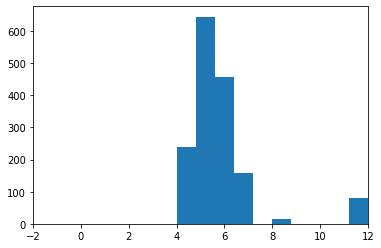

In [8]:
plt.hist(corr_obj.data['opt_lmbda'])
plt.xlim([-2, 12])

#### trf plots..

In [2]:
import matplotlib.pylab as plt
import matplotlib as mpl
%matplotlib inline

In [4]:
from auditory_cortex.plotters.tikzplots import plot_trained_vs_shuffled_network_results
model_names = [
	'whisper_tiny'
	]
trained_identifier = 'mVocs_trf_lags300_l3'
untrained_identifiers = [
		'mVocs_trf_lags300_l3'
						 ]
# plot_trained_vs_shuffled_network_results
tikz_indicator = 'reset-avg'
baseline_identifier = f"STRF_freqs80_mVocs"
save_tikz = False
normalized=True
# threshold=0.088
bin_width = 50
plot_trained_vs_shuffled_network_results(
		model_names=model_names,
		normalized=normalized,
		# threshold=threshold,
		untrained_identifiers = untrained_identifiers,
		trained_identifier = trained_identifier,
		# areas = ['core', 'belt', 'parabelt'],
		baseline_identifier=baseline_identifier,
		plot_difference=False,
		display_dotted_lines=False,
		mVocs=True,
		save_tikz=save_tikz,
		arch_ind_lw=8,
		sig_ind_size=1,
		tikz_indicator=tikz_indicator,
		bin_width=bin_width,
		plot_baseline=False,
		use_stat_inclusion=False,
)

/home/ahmedb/projects/Wav2Letter/deepspeech.pytorch/deepspeech_pytorch/loader/data_loader.py:17: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")


Plotting trained and shuffled distributions for whisper_tiny
Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.089 on column: 'mVocs_normalizer'...


KeyError: 0